# Developing an AI application

Going forward, AI algorithms will be incorporated into more and more everyday applications. For example, you might want to include an image classifier in a smart phone app. To do this, you'd use a deep learning model trained on hundreds of thousands of images as part of the overall application architecture. A large part of software development in the future will be using these types of models as common parts of applications. 

In this project, I will train an image classifier to recognize different species of flowers. You can imagine using something like this in a phone app that tells you the name of the flower your camera is looking at. In practice you'd train this classifier, then export it for use in your application. I will be using [this dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) of 102 flower categories, you can see a few examples below. 

<img src='assets/Flowers.png' width=500px>

The project is broken down into multiple steps:

* Load and preprocess the image dataset
* Train the image classifier on the dataset
* Use the trained classifier to predict image content

In [1]:
# Imports here
import torchvision
from torchvision import datasets, transforms, models
import numpy as np
import torch 
from torch import nn
from torch import optim
from collections import OrderedDict
from PIL import Image
import matplotlib.pyplot as plt
import torch.nn.functional as F
import json
from matplotlib.ticker import FormatStrFormatter

## Load the data

I use `torchvision` to load the data ([documentation](http://pytorch.org/docs/0.3.0/torchvision/index.html)). The dataset is split into three parts, training, validation, and testing. For the training, I have applied transformations such as random scaling, cropping, and flipping. This will help the network generalize leading to better performance. I also made sure the input data is resized to 224x224 pixels as required by the pre-trained networks.

The validation and testing sets are used to measure the model's performance on data it hasn't seen yet. For this you don't want any scaling or rotation transformations, so I resize then crop the images to the appropriate size.

The pre-trained networks were trained on the ImageNet dataset where each color channel was normalized separately. For all three sets I normalize the means and standard deviations of the images to what the network expects. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`, calculated from the ImageNet images.  These values will shift each color channel to be centered at 0 and range from -1 to 1.
 

In [2]:
data_dir = 'flowers'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = data_dir + '/test'

In [3]:
# Define your transforms for the training, validation, and testing sets
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406], 
                                                            [0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406], 
                                                           [0.229, 0.224, 0.225])])

validation_transforms = transforms.Compose([transforms.Resize(256),
                                            transforms.CenterCrop(224),
                                            transforms.ToTensor(),
                                            transforms.Normalize([0.485, 0.456, 0.406], 
                                                                 [0.229, 0.224, 0.225])])

# Load the datasets with ImageFolder
train_data = datasets.ImageFolder(train_dir, transform = train_transforms)
test_data = datasets.ImageFolder(test_dir ,transform = test_transforms)
validation_data = datasets.ImageFolder(valid_dir, transform = validation_transforms)

# Using the image datasets and the trainforms, define the dataloaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size = 64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size = 64, shuffle = True) 
validation_loader = torch.utils.data.DataLoader(validation_data, batch_size = 64,shuffle = True)

### Label mapping

I need to load in a mapping from category label to category name. You can find this in the file `cat_to_name.json`. It's a JSON object which I read in with the [`json` module](https://docs.python.org/2/library/json.html). This will give you a dictionary mapping the integer encoded categories to the actual names of the flowers.

In [4]:
import json

with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)

# Building and training the classifier

Now that the data is ready, it's time to build and train the classifier. I use one of the pretrained models from `torchvision.models` to get the image features. Build and train a new feed-forward classifier using those features.

Things I do next:

* Load a [pre-trained network](http://pytorch.org/docs/master/torchvision/models.html) 
* Define a new, untrained feed-forward network as a classifier, using ReLU activations and dropout
* Train the classifier layers using backpropagation using the pre-trained network to get the features
* Track the loss and accuracy on the validation set to determine the best hyperparameters

In [5]:
# TODO: Build and train your network
model = models.densenet121(pretrained=True)

/opt/conda/lib/python3.6/site-packages/torchvision-0.2.1-py3.6.egg/torchvision/models/densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.torch/models/densenet121-a639ec97.pth
100%|██████████| 32342954/32342954 [00:00<00:00, 51484610.10it/s]


In [6]:
for param in model.parameters():
    param.requires_grad = False
    
classifier = nn.Sequential(OrderedDict([
                          ('fc1', nn.Linear(1024, 500)),
                          ('dropout', nn.Dropout(p=0.6)),
                          ('relu1', nn.ReLU()),
                          ('fc2', nn.Linear(500, 102)),
                          ('output', nn.LogSoftmax(dim=1))
                          ]))
    
model.classifier = classifier

In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device);

In [8]:
# Define loss and optimizer
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)

In [9]:
epochs = 5
print_every = 30
steps = 0
# Implement a function for the validation pass
def validation(model, test_loader, criterion):
    test_loss = 0
    accuracy = 0
    
    for ii, (inputs, labels) in enumerate(test_loader):
        
        inputs, labels = inputs.to(device), labels.to(device)
        output = model.forward(inputs)
        test_loss += criterion(output, labels).item()
        
        ps = torch.exp(output)
        equality = (labels.data == ps.max(dim=1)[1])
        accuracy += equality.type(torch.FloatTensor).mean()
    
    return test_loss, accuracy

In [10]:
print("Training begins...")

for e in range(epochs):
    running_loss = 0
    
    for ii, (inputs, labels) in enumerate(train_loader):
        steps += 1
        
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        # Forward and backward passes
        outputs = model.forward(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        if steps % print_every == 0:
            model.eval()
            valid_loss = 0
            accuracy = 0

            with torch.no_grad():
                valid_loss, accuracy = validation(model, validation_loader, criterion)
            
            print("Epoch: {}/{} | ".format(e+1, epochs),
                  "Training Loss: {:.4f} | ".format(running_loss/print_every),
                  "Validation Loss: {:.4f} | ".format(valid_loss/len(test_loader)),
                  "Validation Accuracy: {:.4f}".format(accuracy/len(test_loader)))
            
            running_loss = 0
            model.train()

print("\nTraining completed!")

Training begins...
Epoch: 1/5 |  Training Loss: 4.4302 |  Validation Loss: 4.0381 |  Validation Accuracy: 0.2169
Epoch: 1/5 |  Training Loss: 3.8674 |  Validation Loss: 3.2909 |  Validation Accuracy: 0.3596
Epoch: 1/5 |  Training Loss: 3.3716 |  Validation Loss: 2.5653 |  Validation Accuracy: 0.4995
Epoch: 2/5 |  Training Loss: 1.4557 |  Validation Loss: 1.9675 |  Validation Accuracy: 0.6163
Epoch: 2/5 |  Training Loss: 2.3791 |  Validation Loss: 1.6285 |  Validation Accuracy: 0.6912
Epoch: 2/5 |  Training Loss: 2.0933 |  Validation Loss: 1.3392 |  Validation Accuracy: 0.7250
Epoch: 3/5 |  Training Loss: 0.2414 |  Validation Loss: 1.1742 |  Validation Accuracy: 0.7623
Epoch: 3/5 |  Training Loss: 1.7002 |  Validation Loss: 0.9824 |  Validation Accuracy: 0.7789
Epoch: 3/5 |  Training Loss: 1.6063 |  Validation Loss: 0.8946 |  Validation Accuracy: 0.8091
Epoch: 3/5 |  Training Loss: 1.5479 |  Validation Loss: 0.7966 |  Validation Accuracy: 0.8438
Epoch: 4/5 |  Training Loss: 0.9502 |  Va

## Testing your network

Run the test images through the network and measure the accuracy.

In [11]:
# Do validation on the test set
correct = 0
total = 0
with torch.no_grad():
    model.eval()
    for data in test_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy achieved on test images is: %d%%' % (100 * correct / total))

Accuracy achieved on test images is: 87%


## Save the checkpoint

Now that our network is trained, I save the model so I can load it later for making predictions. 

In [12]:
# Save the checkpoint
model.class_to_idx = train_data.class_to_idx
checkpoint = {'architecture': 'densenet121',
             'classifier': model.classifier,
             'class_to_idx': model.class_to_idx,
             'state_dict': model.state_dict(),
             'optimizer': optimizer.state_dict(),
             'epochs': epochs}

torch.save(checkpoint, 'mymodel.pth')

## Loading the checkpoint

Now I load a checkpoint and rebuild the model. That way I can come back to this project and keep working on it without having to retrain the network.

In [13]:
# Write a function that loads a checkpoint and rebuilds the model
def load_checkpoint(filepath):
    checkpoint = torch.load(filepath)
    model = getattr(torchvision.models, checkpoint['architecture'])(pretrained=True)
    model.classifier = checkpoint['classifier']
    model.epochs = checkpoint['epochs']
    model.optimizer = checkpoint['optimizer']
    model.load_state_dict(checkpoint['state_dict'])
    model.class_to_idx = checkpoint['class_to_idx']
    
    return model

model = load_checkpoint('mymodel.pth')  
print(model)

/opt/conda/lib/python3.6/site-packages/torchvision-0.2.1-py3.6.egg/torchvision/models/densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.


DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplac

# Inference for classification

I write a function to use a trained network for inference. That is, you'll pass an image into the network and predict the class of the flower in the image. I write a function called `predict` that takes an image and a model, then returns the top $K$ most likely classes along with the probabilities.


## Image Preprocessing

I use `PIL` to load the image ([documentation](https://pillow.readthedocs.io/en/latest/reference/Image.html)). I write a function that preprocesses the image so it can be used as input for the model. This function should process the images in the same manner used for training. 

First, i resize the images where the shortest side is 256 pixels, keeping the aspect ratio. This can be done with the [`thumbnail`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) or [`resize`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) methods. Then I need to crop out the center 224x224 portion of the image.

Color channels of images are typically encoded as integers 0-255, but the model expected floats 0-1. I will also need to convert the values.

As before, the network expects the images to be normalized in a specific way. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`. I will subtract the means from each color channel, then divide by the standard deviation. 

And finally, PyTorch expects the color channel to be the first dimension but it's the third dimension in the PIL image and Numpy array. I reorder dimensions using [`ndarray.transpose`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.ndarray.transpose.html). The color channel needs to be first and retain the order of the other two dimensions.

In [14]:
def process_image(image_path):
    image_transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    image_tensor = image_transform(Image.open(image_path))
    return image_tensor
    
image_path = (data_dir + '/test' + '/100/' + 'image_07896.jpg')
image_tensor = process_image(image_path)
print(image_tensor.shape)

torch.Size([3, 224, 224])


To check my work, the function below converts a PyTorch tensor and displays it in the notebook. If our `process_image` function works, running the output through this function should return the original image (except for the cropped out portions).

In [15]:
def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.numpy().transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

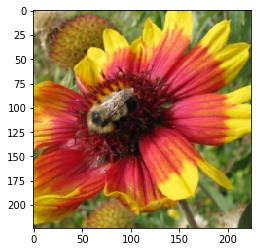

In [16]:
imshow(process_image("flowers/test/100/image_07896.jpg"))

## Class Prediction

Once we get images in the correct format, it's time to write a function for making predictions with your model. A common practice is to predict the top 5 or so (usually called top-$K$) most probable classes. 

To get the top $K$ largest values in a tensor I use [`x.topk(k)`](http://pytorch.org/docs/master/torch.html#torch.topk). This method returns both the highest `k` probabilities and the indices of those probabilities corresponding to the classes. 

Again, this method will take a path to an image and a model checkpoint, then return the probabilities and classes.

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

In [17]:
def predict(image_path, model, topk):
    # Implement the code to predict the class from an image file
    image_torch = process_image(image_path)
    image_torch = image_torch.unsqueeze_(0)
    image_torch = image_torch.float()
    model.eval()
    output = model.forward(image_torch.cuda())
    probability = F.softmax(output.data,dim=1)
    
    #storing the probablities and indices corresponding to classes
    probabilities = np.array(probability.topk(topk)[0][0])
    indices = np.array(probability.topk(topk)[1][0])
    
    index_to_class = {val: key for key, val in model.class_to_idx.items()} #invert the dictionary
    top_classes = [np.int(index_to_class[index]) for index in indices]
    
    return probabilities, top_classes

In [18]:
image = ('flowers/test/1/image_06743.jpg')
top_probabilities, top_classes = predict(image, model.cuda(), 6)
print(top_probabilities)
print(top_classes)

[ 0.77583462  0.05793543  0.02861085  0.01799451  0.01180796  0.00943287]
[1, 70, 51, 86, 52, 76]


## Sanity Checking

Now that I can use a trained model for predictions, let's check to make sure it makes sense. Even if the testing accuracy is high, it's always good to check that there aren't obvious bugs. 

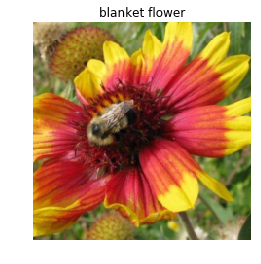

([<matplotlib.axis.YTick at 0x7f965b4a99b0>,
 <a list of 5 Text yticklabel objects>)

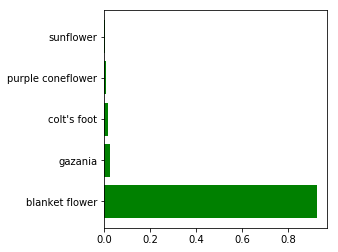

In [19]:
# Display an image along with the top 5 classes
plt.figure(figsize=(4,4))
    
path = ('flowers/test/100/image_07896.jpg')
    
probs, classes = predict(path, model, 5)
image = process_image(path)
    
axes = imshow(image, ax = plt)
axes.axis('off')
axes.title(cat_to_name[str(classes[0])])
axes.show()

plt.figure(figsize=(4,4))

flower_names = [cat_to_name[str(index)] for index in classes]
ylabels = np.arange(len(flower_names))
value = np.array(probs)

plt.barh(ylabels, value, color='green', align='center')
plt.yticks(ylabels, flower_names)